## Experiments performed on real dataset

In [ ]:
! pip install git+https://github.com/pbudzyns/ad_toolkit.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pbudzyns/ad_toolkit.git to /tmp/pip-req-build-dwyk5gu8
  Running command git clone -q https://github.com/pbudzyns/ad_toolkit.git /tmp/pip-req-build-dwyk5gu8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for ad-toolkit: filename=ad_toolkit-0.0.1-py3-none-any.whl size=48911 sha256=e73e00b8e94f7fdf8ce3d8398ffe63e391e3f54a6e3b0cd049c31255d9fa46ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ksj3gi9/wheels/3b/26/41/35e592529c0fe767df03084950d3189ea49d604fec2e0c41ff
Successfully built ad-toolkit


In [1]:
import math
import pickle
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ad_toolkit.detectors import AutoEncoder, VariationalAutoEncoder, LSTM_AD, LSTM_ED
from ad_toolkit.evaluation import Result, TimeSeriesPlot

In [2]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = pathlib.Path("/content/drive/MyDrive/sops_anomaly_notebook")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def max_metric(scores, targets, threshold_range, metric):
    best_metric = -1
    best_result = None
    best_threshold = 0
    for threshold in threshold_range:
        labels = (scores > threshold).astype(np.int32)
        result = Result(labels, targets)
        current_metric = getattr(result, metric, -1)
        if current_metric > best_metric:
            best_metric = current_metric
            best_result = result
            best_threshold = threshold
    return best_result, best_threshold, best_metric

def best_result(predictions, targets, max_error=None):
    """Try various threshold levels to get best scores."""
    
    if max_error is None:
        threshold_range = np.linspace(
            np.min(predictions), 
            min(3*np.mean(predictions), np.max(predictions)),
#             np.max(predictions),
            200,
        )
    else:
        threshold_range = np.linspace(0, max_error, 100)
        
    if np.any(targets):
        # If dataset contains anomalies maximize f1 score.
        result, threshold, _ = max_metric(predictions, targets, threshold_range, 'f1')
    else:
        # If dataset contains no anomalies maximize accuracy.
        result, threshold, _ = max_metric(predictions, targets, threshold_range, 'accuracy')
    return result, threshold

def save_anomalies(anomalies, filename):
    file = pathlib.Path('../results/esa/') / filename
    pd.Series(anomalies, index=labels.index).to_csv(file)

## Load data and filter data for selected time range

### Normalize and plot dataset

In [4]:
START, END = '2019-09-20', '2019-10-01'
train_data = pd.read_csv(root_dir / "data" / "train_data.csv", parse_dates=True, index_col="date")

label_data = pd.read_csv(root_dir / "data" / "labels.csv", index_col='index')
ranges = []
for _, row in label_data.iterrows():
    ranges.append((row['Start-Time'], row['End-Time']))

labels = pd.Series(np.zeros((len(train_data, ))), index=train_data.index)
for start, end in ranges:
    labels[start:end] = 1
    
labels = labels[START:END]

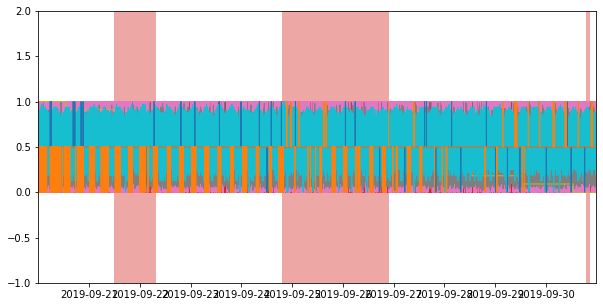

In [5]:
TimeSeriesPlot.plot(train_data, labels=labels, vertical_margin=1)

## Fitting Autoencoder

In [6]:
model = AutoEncoder(window_size=20, layers=(128, 64, 32,), latent_size=16, use_gpu=True)
model.train(train_data, epochs=30, learning_rate=1e-4, verbose=True)

Epoch 0 train_loss: 0.2443161361875969, valid_loss: 0.05213729541433248
Epoch 1 train_loss: 0.019135208617946185, valid_loss: 0.04655347325070968
Epoch 2 train_loss: 0.01714659667246648, valid_loss: 0.04561347503149648
Epoch 3 train_loss: 0.0169528549776186, valid_loss: 0.04515079436835725
Epoch 4 train_loss: 0.016809111215627275, valid_loss: 0.044808257289845686
Epoch 5 train_loss: 0.016068584757630486, valid_loss: 0.044017768027140275
Epoch 6 train_loss: 0.013969280146616133, valid_loss: 0.04218285008047349
Epoch 7 train_loss: 0.012475685166144694, valid_loss: 0.04126835105527803
Epoch 8 train_loss: 0.01195244411182766, valid_loss: 0.04091827322302584
Epoch 9 train_loss: 0.011531304725370294, valid_loss: 0.040878638101351006
Epoch 10 train_loss: 0.010897333623614867, valid_loss: 0.04082206566175473
Epoch 11 train_loss: 0.010310965520959045, valid_loss: 0.04052617065085592
Epoch 12 train_loss: 0.009916821387722282, valid_loss: 0.040070228110901614
Epoch 13 train_loss: 0.00965114036965

In [7]:
scores = model.predict(train_data)
result, threshold = best_result(scores, labels)
result

Result(accuracy=0.73,
	(tp, fp, tn, fn)=(47329, 113135, 301425, 14814),
	precision=0.29,
	recall=0.76,
	f1=0.43,
	roc_auc=0.74,
	y_pred%=0.33661210439204287,
	y_label%=0.13035999353895403,
)

In [17]:
# Manually adjust threshold to get reasonable amount of anomalies
anomalies = (scores > threshold + 0.1).astype(np.int32)
anomalies.sum()

5003

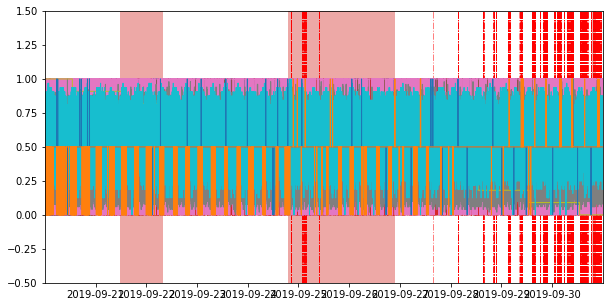

In [18]:
TimeSeriesPlot.plot(
    train_data, labels=labels, vertical_margin=0.5, 
    anomalies={'ae': anomalies}, anomaly_style_kwargs={'alpha': 0.5, 'lw': 1},
)

In [19]:
raw_scores = model.predict(train_data, raw_errors=True)

In [20]:
pickle.dump(anomalies, (root_dir / "ae_esa_anom.pkl").open('wb'))
pickle.dump(raw_scores, (root_dir / "ae_esa_raw.pkl").open('wb'))

In [ ]:
# save_anomalies(anomalies, 'autoencoder.csv')

## Fit VariationalAutoEncoder

In [ ]:
model = VariationalAutoEncoder(window_size=10, layers=(64, 32,), latent_size=16)
model.train(train_data, epochs=10, learning_rate=1e-4, verbose=True)

Epoch 0 loss: 0.036932416321200055
Epoch 1 loss: 0.028138960370686247
Epoch 2 loss: 0.028121159673381083
Epoch 3 loss: 0.028115814444331942
Epoch 4 loss: 0.028112738027579735
Epoch 5 loss: 0.02811257327671788
Epoch 6 loss: 0.028109519632940047
Epoch 7 loss: 0.02810697036461536
Epoch 8 loss: 0.028106442917026738
Epoch 9 loss: 0.02810522840838397


In [ ]:
scores = model.predict(train_data)
result, threshold = best_result(scores, labels)
result

Result(accuracy=0.63,
	(tp, fp, tn, fn)=(49180, 164202, 250358, 12963),
	precision=0.23,
	recall=0.79,
	f1=0.36,
	roc_auc=0.7,
	y_pred%=0.4476204261353505,
	y_label%=0.13035999353895403,
)

In [ ]:
# Manually adjust threshold to get reasonable amount of anomalies
anomalies = (scores > threshold + 0.14).astype(np.int32)
anomalies.sum()

347

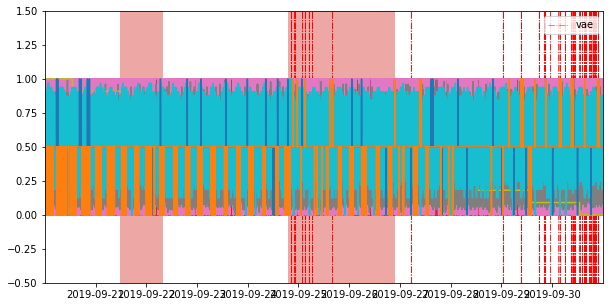

In [ ]:
TimeSeriesPlot.plot(
    train_data, labels=labels, vertical_margin=0.5, 
    anomalies={'vae': anomalies}, anomaly_style_kwargs={'alpha': 0.5, 'lw': 1},
)

In [ ]:
save_anomalies(anomalies, 'variationalautoencoder.csv')

### Fit LSTM_AD

In [ ]:
model = LSTM_AD(window_size=10, hidden_size=16, use_gpu=True)
model.train_with_slices(train_data, slice_len=1000, epochs=3, learning_rate=1e-4, verbose=True)

Epoch 0 loss: 0.37465791162834444
Epoch 0 loss: 0.37420316686097704
Epoch 0 loss: 0.4113705979396138
Epoch 0 loss: 0.3631068467180995
Epoch 0 loss: 0.4216437150062622
Epoch 0 loss: 0.38216335153379044
Epoch 0 loss: 0.38333953899525863
Epoch 0 loss: 0.37935947959881366
Epoch 0 loss: 0.40429547431433666
Epoch 0 loss: 0.35674745247077383
Epoch 0 loss: 0.39261457344493617
Epoch 0 loss: 0.38332957585856764
Epoch 0 loss: 0.3952858643238163
Epoch 0 loss: 0.4116390975871874
Epoch 0 loss: 0.37103530165132803
Epoch 0 loss: 0.3735711292625512
Epoch 0 loss: 0.40550457667196377
Epoch 0 loss: 0.35707883710529686
Epoch 0 loss: 0.3812723983889618
Epoch 0 loss: 0.4148467056562302
Epoch 0 loss: 0.3710126721411073
Epoch 0 loss: 0.41266696909158973
Epoch 0 loss: 0.40091887087630723
Epoch 0 loss: 0.39282641761714576
Epoch 0 loss: 0.37078942921478925
Epoch 0 loss: 0.4163425368008031
Epoch 0 loss: 0.38275764473459484
Epoch 0 loss: 0.3922225533524846
Epoch 0 loss: 0.4275104750996504
Epoch 0 loss: 0.3935590132

In [ ]:
scores = model.predict(train_data)
result, threshold = best_result(scores, labels)
result

Result(accuracy=0.13,
	(tp, fp, tn, fn)=(62143, 414559, 1, 0),
	precision=0.13,
	recall=1.0,
	f1=0.23,
	roc_auc=0.5,
	y_pred%=0.9999979022577999,
	y_label%=0.13035999353895403,
)

In [ ]:
# Manually adjust threshold to get reasonable amount of anomalies
anomalies = (scores > threshold + 290).astype(np.int32)
anomalies.sum()

312

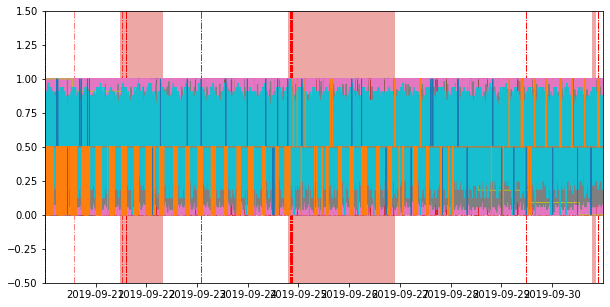

In [ ]:
TimeSeriesPlot.plot(
    train_data, labels=labels, vertical_margin=0.5, 
    anomalies={'lstm_ad': anomalies}, anomaly_style_kwargs={'alpha': 0.5, 'lw': 1},
)

In [ ]:
save_anomalies(anomalies, root_dir / 'results' / 'esa'/ 'lstm_ad.csv')

## Fit LSTM_ED

In [6]:
model = LSTM_ED(sequence_len=500, stride=500, hidden_size=16, use_gpu=True)
model.train(train_data, epochs=10, learning_rate=1e-4, verbose=True)

Epoch 0 loss: 2483.17509765625
Epoch 1 loss: 2480.48515625
Epoch 2 loss: 2455.93740234375
Epoch 3 loss: 2431.7486328125
Epoch 4 loss: 2420.61142578125
Epoch 5 loss: 2390.307958984375
Epoch 6 loss: 2380.67568359375
Epoch 7 loss: 2378.280859375
Epoch 8 loss: 2340.81279296875
Epoch 9 loss: 2338.145654296875


In [ ]:
scores = []
done = 0
slice_len = 1000
# step = len(train_data) // n_parts
for i in range(math.ceil(len(train_data) / slice_len)):
    print(f"Processing {i} part. {done} samples done.")
    p = model.predict(train_data[i*slice_len:(i+1)*slice_len])
    done += len(p)
    scores.append(p)
scores = np.concatenate(scores)
s = np.zeros((len(train_data),))
s[:len(scores)] = scores
result, threshold = best_result(s, labels)
result

Processing 0 part. 0 samples done.
Processing 1 part. 1000 samples done.
Processing 2 part. 2000 samples done.
Processing 3 part. 3000 samples done.
Processing 4 part. 4000 samples done.
Processing 5 part. 5000 samples done.
Processing 6 part. 6000 samples done.
Processing 7 part. 7000 samples done.
Processing 8 part. 8000 samples done.
Processing 9 part. 9000 samples done.
Processing 10 part. 10000 samples done.
Processing 11 part. 11000 samples done.
Processing 12 part. 12000 samples done.
Processing 13 part. 13000 samples done.
Processing 14 part. 14000 samples done.
Processing 15 part. 15000 samples done.
Processing 16 part. 16000 samples done.
Processing 17 part. 17000 samples done.
Processing 18 part. 18000 samples done.
Processing 19 part. 19000 samples done.
Processing 20 part. 20000 samples done.
Processing 21 part. 21000 samples done.
Processing 22 part. 22000 samples done.
Processing 23 part. 23000 samples done.
Processing 24 part. 24000 samples done.
Processing 25 part. 250

In [ ]:
# s = np.zeros((len(train_data),))
# s[:len(scores)] = scores
threshold

0.012685905663933836

In [ ]:
# Manually adjust threshold to get reasonable amount of anomalies
anomalies = (s > threshold + 0.75).astype(np.int32)
anomalies.sum()

655

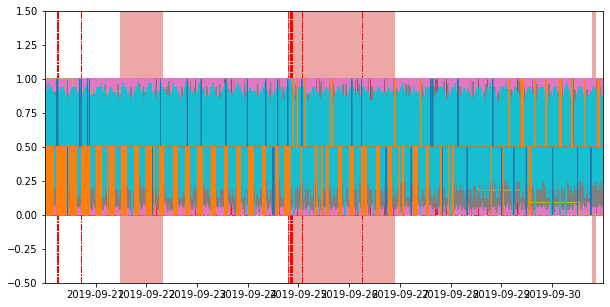

In [ ]:
TimeSeriesPlot.plot(
    train_data, labels=labels, vertical_margin=0.5, 
    anomalies={'lstm_ed': anomalies}, anomaly_style_kwargs={'alpha': 0.5, 'lw': 1},
)

In [ ]:
save_anomalies(anomalies, root_dir / 'results' / 'esa'/ 'lstm_ed.csv')

### Fit Donut

In [1]:
! pip install "ad_toolkit[donut] @ git+https://github.com/pbudzyns/ad_toolkit.git"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pbudzyns/ad_toolkit.git to /tmp/pip-install-2boneoqd/ad-toolkit_48e7a80e5f9d43a1a383479a5d5bd374
  Running command git clone -q https://github.com/pbudzyns/ad_toolkit.git /tmp/pip-install-2boneoqd/ad-toolkit_48e7a80e5f9d43a1a383479a5d5bd374
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/haowen-xu/tfsnippet.git (to revision v0.1.2) to /tmp/pip-install-2boneoqd/tfsnippet_345204e358124f3b8fd4539e6b4e0def
  Running command git clone -q https://github.com/haowen-xu/tfsnippet.git /tmp/pip-install-2boneoqd/tfsnippet_345204e358124f3b8fd4539e6b4e0def
  Running command git checkout -q ecc0b4d1e610cf8cfa8c236857a7dabee27d5543
  Cloning https://github.com/korepwx/donut.git to /tmp/pip-install-2boneoqd/donut_1483461b34f64e84a1435c94658ba68b
  Running command git clon

In [7]:
import tensorflow as tf

from ad_toolkit.detectors import Donut

In [8]:
import datetime

def fake_timestamp(data):
    new_data = data.copy()
    start = data.index[0].to_pydatetime()
    new_idx = [start]
    for i in range(1, len(data)):
        new_idx.append(start + datetime.timedelta(seconds=i))
    new_data.index = [x.timestamp() for x in new_idx]
    return new_data

In [ ]:
columns = train_data.columns
column = columns[4] # 8,10,11 was skipped
print(column)

model_input = train_data[column]
model_input.index = train_data.index
model_input.index.name = 'timestamp'
model_input = pd.DataFrame(model_input)
# Used implemenetation have strict check of timestamps
train_fake = fake_timestamp(model_input)

with tf.Graph().as_default() as graph, tf.device('/gpu:0'):
    model = Donut(window_size=200, layers=(128,64,32,), latent_size=16)
    model.train(train_fake, labels=labels, epochs=15)
    scores = model.predict(train_fake)
    
all_scores = np.concatenate(scores)
pickle.dump(all_scores, (root_dir / f"donut_{column}.pkl").open('wb'))